# Third Point

Use transfer learning based on a pre-trained network in two manners.

In [1]:
import cv2 as cv2
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import optimizers, initializers
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, AveragePooling2D
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, History
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import import_ipynb
import dataSetUtility as dsu
import plottingUtility as pltu

importing Jupyter notebook from dataSetUtility.ipynb
importing Jupyter notebook from plottingUtility.ipynb


Read all images and create a Training Data

In [2]:
#path to the directories
pathTrain=r'C:\Users\adria\Desktop\CVPR\ImageSet\train'
pathTest=r'C:\Users\adria\Desktop\CVPR\ImageSet\test'

labels = [os.path.basename(i) for i in glob.glob(pathTrain + '/*', recursive=True)]
numberOfClasses = len(labels)
print("Class number: ", numberOfClasses)
print("Class names: ", labels)

Class number:  15
Class names:  ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


To use images on VGG they need to have size (224, 224)

In [3]:
xTrain, yTrain = dsu.loadImages(pathTrain, labels, dimension=224)
xTest, yTest = dsu.loadImages(pathTest, labels, dimension=224)

create a list of images for train and test set

In [4]:
trainImagesList = []
testImagesList = []
for label in labels:
    sTrain = pathTrain+'/'+label+'/{}'
    sTest = pathTest+'/'+label+'/{}'
    tempTrain = [sTrain.format(i) for i in os.listdir(pathTrain+'/'+label+'/')]
    tempTest = [sTest.format(i) for i in os.listdir(pathTest+'/'+label+'/')]
    trainImagesList = trainImagesList + tempTrain
    testImagesList = testImagesList + tempTest

prepocessing images using keras libraries for VGG

In [5]:
trainImages = []
for img in trainImagesList:
    tmp = image.load_img(img, target_size=(224,224))
    tmp = image.img_to_array(tmp)
    trainImages.append(tmp)


trainImages=np.array(trainImages)
trainImg=preprocess_input(trainImages)
trainLabelsDummy=to_categorical(yTrain,15)

In [6]:
testImages = []
for img in testImagesList:
    tmp = image.load_img(img, target_size=(224,224))
    tmp = image.img_to_array(tmp)
    testImages.append(tmp)

testImages=np.array(testImages)
testImg=preprocess_input(testImages)
testLabelsDummy=to_categorical(yTest,15)

We build the VGG16 model

In [7]:
adam = optimizers.Adam()
vgg = VGG16(weights='imagenet', include_top=True)
model = Sequential()
#freeze all layers except the last one

for layer in vgg.layers[:-1]:
    layer.trainable = False
    model.add(layer)
    
model.add(Dense(15, activation='softmax'))

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
earlyStopping = EarlyStopping(min_delta=0.00,patience = 5)
history = model.fit(trainImg,trainLabelsDummy,batch_size=64,
                    epochs=10,validation_split=0.15,shuffle=True,
                    callbacks=[earlyStopping])

Epoch 1/10
20/20 [==============================] - 150s 8s/step - loss: 1.9002 - accuracy: 0.4581 - val_loss: 13.7742 - val_accuracy: 0.1111
Epoch 2/10
20/20 [==============================] - 151s 8s/step - loss: 0.2766 - accuracy: 0.8986 - val_loss: 15.1802 - val_accuracy: 0.0978
Epoch 3/10
20/20 [==============================] - 152s 8s/step - loss: 0.1378 - accuracy: 0.9560 - val_loss: 15.6132 - val_accuracy: 0.0978
Epoch 4/10
20/20 [==============================] - 148s 7s/step - loss: 0.0985 - accuracy: 0.9745 - val_loss: 14.9936 - val_accuracy: 0.1067
Epoch 5/10
20/20 [==============================] - 152s 8s/step - loss: 0.0605 - accuracy: 0.9901 - val_loss: 15.4338 - val_accuracy: 0.1022
Epoch 6/10
20/20 [==============================] - 148s 7s/step - loss: 0.0452 - accuracy: 0.9967 - val_loss: 15.1075 - val_accuracy: 0.1067


In [9]:
ev = model.evaluate(testImg, testLabelsDummy)

94/94 [==============================] - 352s 4s/step - loss: 2.6001 - accuracy: 0.7605


In [10]:
prediction = model.predict(testImg)

ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [12]:
yPred = dsu.predictClass(prediction)
cm=confusion_matrix(yTest, yPred)

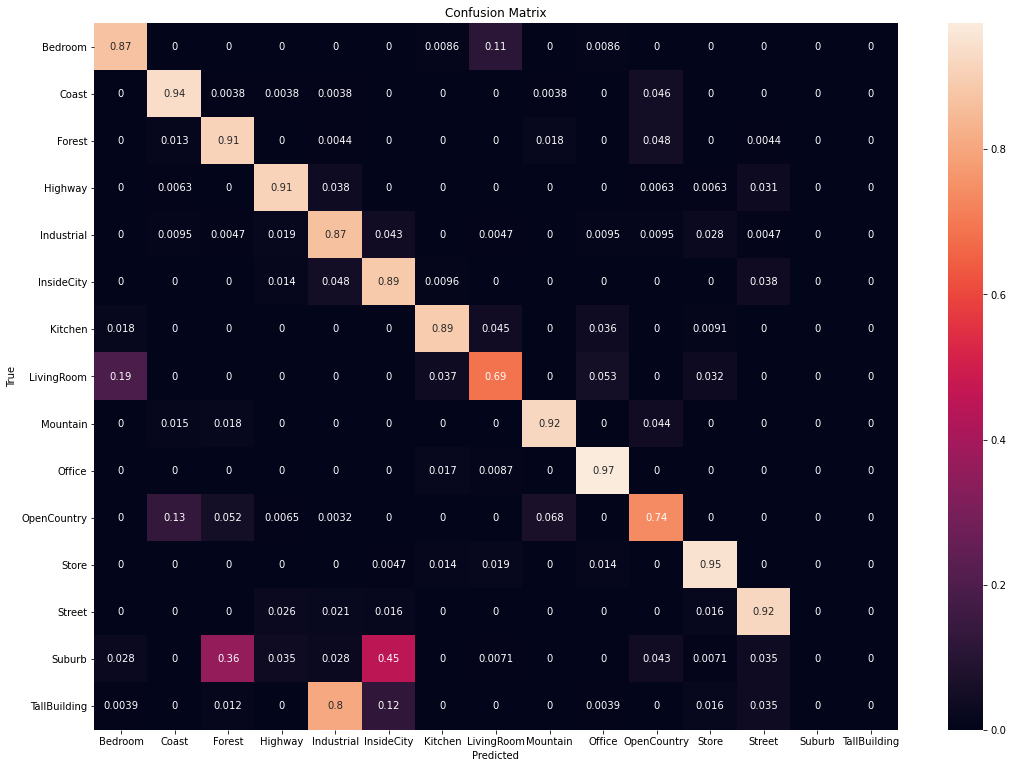

In [14]:
pltu.plotConfusionMatrix(cm, labels, "confusion_matrix_1", "images_point_three/")

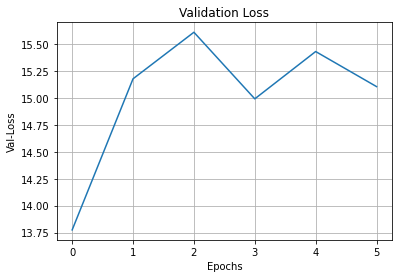

In [15]:
pltu.validationLoss(history, "images_point_three", "validation_loss_1")

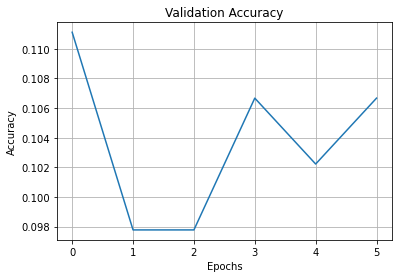

In [16]:
pltu.validationAccuracy(history, "images_point_three", "validation_acc_1")

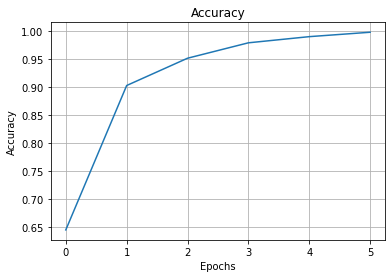

In [17]:
pltu.plottingAccuracy(history, "images_point_three", "accuracy_1")

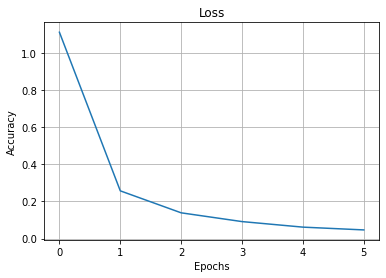

In [18]:
pltu.plottingLoss(history, "images_point_three", "loss_1")

## Employ pre-trained network

We are going to extract features obtained in the last convolutional layer of the VGG16. for each image, we will obtain 512 features, each of them is a 7x7 grid of values. To make these feature suitable for a SVM, we will flatten all the 512 features related to a specific image in a unique long vector.

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from keras.utils import np_utils
from keras.applications import VGG16, imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import GlobalAveragePooling2D

In [20]:
xTrain, yTrain = dsu.loadImages(pathTrain, labels, dimension=224)
xTest, yTest = dsu.loadImages(pathTest, labels, dimension=224)

In [21]:
yTrainDummy = to_categorical(yTrain, 15)
yTestDummy = to_categorical(yTest, 15)

In [22]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

58892288/58889256 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

### Extract the features

we define a function to extract the feature from image. This function take in input the path of images, the labels and the modle. From this value we load all images, prepocess they and extract the feature

In [25]:
def extractFeatures(model, path, labels):
    
    pathImages = []
    for label in labels:
        s = path+'/'+label+'/{}'
        temp = [s.format(i) for i in os.listdir(path+'/'+label+'/')]
        pathImages = pathImages + temp
    
    res = []
    count = 0
    for p in pathImages:
        count += 1
        img = load_img(p, target_size=(224,224))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = imagenet_utils.preprocess_input(img)
        res.append(img)
        
    images = np.vstack(res)
    features = model.predict(images, batch_size=64)
    featuresFlatten = features.reshape((features.shape[0], 7 * 7 * 512))
    
    return images, features, featuresFlatten

In [26]:
trainImages, featureMatrix, featureArray = extractFeatures(model, pathTrain, labels)

In [27]:
testImages, featureMatrixTest, featureArrayTest = extractFeatures(model, pathTest, labels)

Now we use the SVM to predict classes of test data

In [29]:
classif = [SVC(kernel="linear") for _ in range(numberOfClasses)]

currentLabel = 0
for clf in classif:
    print(currentLabel)
    v = np.array([1 if label==currentLabel else 0 for label in yTrain])
    clf = clf.fit(featureArray, v)
    currentLabel += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [30]:
prediction = []
for image in featureArrayTest:
    pred = np.array([np.dot(clf.coef_,image) + clf.intercept_ for clf in classif])
    prediction.append(np.argmax(pred))
    
prediction = np.asarray(prediction)

In [34]:
cont=0
for i in range(len(prediction)):
    if prediction[i]==yTest[i]:
        cont += 1
    else:
        continue
        
accuracy = cont/len(prediction)
print("Accuracy value: ",accuracy)

Accuracy value:  0.8991624790619765


Now, we evaluate the qualitu of prediction of the linear swm

In [35]:
tp = []
fp = []
fn = []
tn = []
for i in range(numberOfClasses):
    tp_temp = 0
    fp_temp = 0
    fn_temp = 0
    tn_temp = 0
    
    for j in range(len(prediction)):
        if(prediction[j]==i and yTest[j]==i):
            tp_temp += 1
        if(prediction[j]==i and yTest[j]!=i):
            fp_temp += 1
        if(prediction[j]!=i and yTest[j]==i):
            fn_temp += 1
        if(prediction[j]!=i and yTest[j]!=i):
            tn_temp += 1
    tp.append(tp_temp)
    fp.append(fp_temp)
    fn.append(fn_temp)
    tn.append(tn_temp)

In [37]:
data = {'labels':labels , 'True positive':tp,'True negative':tn,'False positive':fp,'False negative':fn}
evaluation = pd.DataFrame(data, columns = ['labels','True positive','True negative','False positive','False negative'])
print("Evaluation: ")
evaluation

Evaluation: 


,labels,True positive,True negative,False positive,False negative
0,Bedroom,91,2843,26,25
1,Coast,237,2695,30,23
2,Forest,220,2734,23,8
3,Highway,151,2815,10,9
4,Industrial,169,2765,9,42
5,InsideCity,178,2761,16,30
6,Kitchen,101,2863,12,9
7,LivingRoom,147,2762,34,42
8,Mountain,256,2691,20,18
9,Office,113,2856,14,2


Build confusion matrix

In [38]:
cm = np.zeros((15,15))
for i in range(numberOfClasses):
    cm[i,i] = evaluation.loc[i]['True positive']
    
for i in range(numberOfClasses):
    for j in range(numberOfClasses):
        temp = 0
        for k in range(len(yTest)):
            if(yTest[k]==i and prediction[k]==j):
                temp += 1
        cm[i,j]=temp

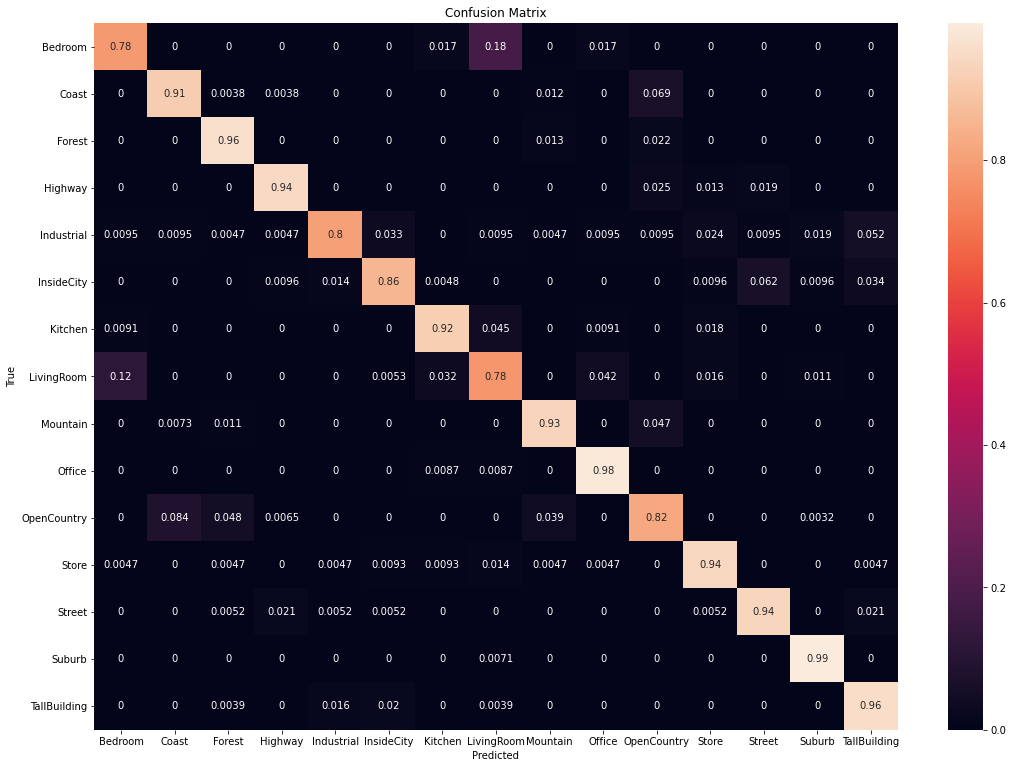

In [39]:
pltu.plotConfusionMatrix(cm, labels, "confusion_matrix_2", "images_point_three/")